# Analysis for repeating text experiment

This code lets you produce plots that compare human and model behavior on the span repetition experiment. Right now, this only uses data averaged across participants (not per-participant data).

You'll need `data_aggregate_opt.joblib` , which is a joblib pickle file that contains all the data.

In [1]:
%matplotlib inline

import collections

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
pickle_fname = 'data_aggregate_opt.joblib'

with open(pickle_fname, 'rb') as f:
    data = joblib.load(f)
    print('Adding variables:', list(data.keys()))
    locals().update(data)

Adding variables: ['story_avg_accs', 'story_prompt_words', 'story_span_lens', 'story_num_repeats', 'story_words']


In [3]:
print('Available stimuli:', list(story_avg_accs.keys()))

Available stimuli: ['wheretheressmoke', 'fromboyhoodtofatherhood', 'onapproachtopluto', 'eyespy', 'souls']


In [4]:
perf_pretty_names = {'is_correct': 'Humans', 'baseline_acc': 'Model (pre-opt.)',
                     'final_acc_mean': 'Model (post-opt.)', 'val': 'Validation set'}
perf_colors = {'is_correct': 'olivedrab', 'baseline_acc': 'purple', 'final_acc_mean': 'hotpink'}

In [9]:
plot_story = next(iter(story_avg_accs.keys()))
print("Plotting data for stimulus:", plot_story)

story_perf_df = story_avg_accs[plot_story]

Plotting data for stimulus: wheretheressmoke


In [15]:
# What data is available?
story_perf_df.head()

,word_idx,word,repeat_idx,is_stopword,is_correct,Reaction Time,Reaction Time_no-timeout,num_subjects,baseline_acc,final_acc_mean,final_acc_sem
total_word_idx,,,,,,,,,,,
2.0,2.0,to,0.0,True,0.240000,4978.466840,4293.986364,25,0.093663,0.092719,0.005669
3.0,3.0,trade,0.0,False,0.000000,5254.377000,4551.725926,31,0.000076,0.000121,0.000015
10.0,10.0,from,0.0,True,0.000000,6104.919571,5258.400000,28,0.001969,0.003320,0.000416
14.0,14.0,both,0.0,True,0.230769,6072.053731,5358.072727,26,0.531476,0.497980,0.044970
17.0,17.0,newish,0.0,False,0.000000,5278.540517,4928.851852,29,0.282593,0.269870,0.015729


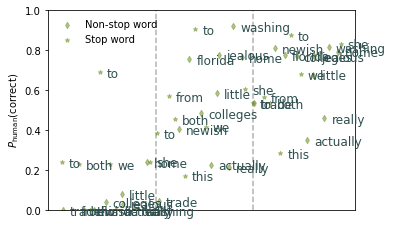

In [27]:
# Plot the behavioral data for a single story
fig, ax = plt.subplots(figsize=np.array([1., 4./6])*5.5)
stopword_style = {False: {'marker': 'd',}, True: {'marker': '*'}}
stopword_pretty_label = {True: 'Stop word', False: 'Non-stop word'}
for is_stopword, stopword_prompt_df in story_perf_df.groupby('is_stopword'):
    stopword_prompt_df.reset_index().plot.scatter(ax=ax, x='total_word_idx', y='is_correct', color=[perf_colors['is_correct']], alpha=0.5, s=20, label=stopword_pretty_label[is_stopword], **stopword_style[is_stopword])
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel(r'$P_{\mathregular{human}}(\mathregular{correct})$')
plt.ylim(0,1)
for word_pos, word in story_perf_df['word'].iteritems():
    ax.annotate(word, (word_pos, story_perf_df.loc[word_pos, 'is_correct']),
                xytext=(7,-5), textcoords='offset points',
                fontsize=12, color='darkslategrey')

# Mark the start of each presentation
for repeat_idx in range(1, story_num_repeats[plot_story]+1):
    repeat_start_idx = repeat_idx * (story_span_lens[plot_story]+1)
    ax.axvline(repeat_start_idx, -100, 100, color='k', ls='--', zorder=-0, alpha=0.3)
    
ax.legend(frameon=False);

#ax.set_title(f"story {story}\n$\\rho={plot_corrs['all']:0.3f}$ (all words); $\\rho={plot_corrs['stopwords']:0.3f}$ (stop); $\\rho={plot_corrs['content']:0.3f}$ (other)")

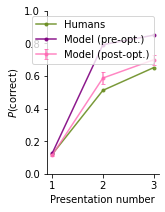

In [28]:
# Average by presentation
fig, ax = plt.subplots(figsize=np.array([1., 6./4])*2)
human_grouped = story_perf_df.groupby('repeat_idx')
human_grouped[['is_correct', 'baseline_acc']].mean().rename(perf_pretty_names, axis=1).plot(ax=ax, color=[perf_colors[x] for x in ['is_correct', 'baseline_acc']], marker='.', alpha=0.9)

# Unlike in the paper, we're averaging across trials and *then* across presentations.
# Changes the curve slightly, but doesn't require loading GBs of metrics from the optimization process.
human_grouped[['final_acc_mean', 'final_acc_sem']].mean().plot(ax=ax, y='final_acc_mean', label=perf_pretty_names['final_acc_mean'], yerr='final_acc_sem', color=[perf_colors['final_acc_mean']], marker='.', alpha=0.8, capsize=2)
pres_idxs = np.arange(story_num_repeats[plot_story]+1)
ax.set_xticks(pres_idxs, pres_idxs+1) # renumber repeat_idx --> pres. number
ax.set_ylim(0., 1.)
ax.set_xlabel('Presentation number')
ax.set_ylabel('$P$(correct)')
for x in ['right', 'top']: ax.spines[x].set_visible(False)

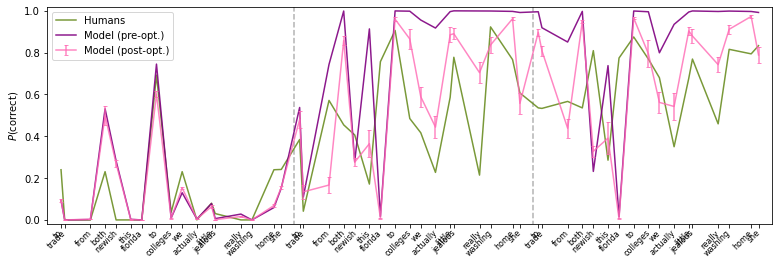

In [34]:
# Plot average timecourse
fig, ax = plt.subplots(figsize=(13., 4.))
story_perf_df[['is_correct', 'baseline_acc']].rename(perf_pretty_names, axis=1).plot(ax=ax, alpha=0.9, color=[perf_colors[x] for x in ['is_correct', 'baseline_acc']])
story_perf_df.plot(ax=ax, y='final_acc_mean', yerr='final_acc_sem', alpha=0.8, color=[perf_colors['final_acc_mean']], label=perf_pretty_names['final_acc_mean'], capsize=2)
ax.set_xticks(story_perf_df.index, story_perf_df['word'], rotation=45,
              fontsize=8, ha='right', va='center', rotation_mode='anchor');
ax.margins(0.02) # slightly smaller margins
ax.set_xlabel('')
ax.set_ylabel('$P$(correct)')

# Draw boundaries between presentations
for repeat_idx in range(1, story_num_repeats[plot_story]+1):
    repeat_start_idx = repeat_idx * (story_span_lens[plot_story]) + .5
    ax.axvline(repeat_start_idx, -100, 100, color='k', ls='--', zorder=-0, alpha=0.3)
    
opt_lines_handles_labels = ax.get_legend_handles_labels()

Text(0.5, 1.0, 'wheretheressmoke')

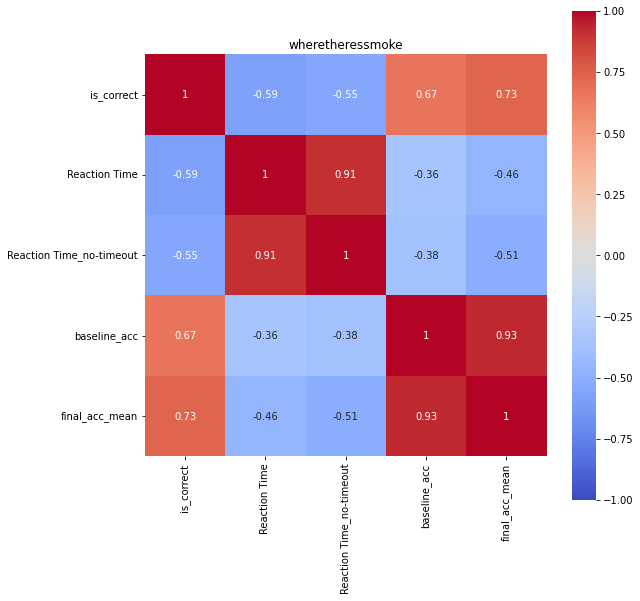

In [36]:
# How correlated are human behavior, model behavior, and ablated model behavior?
fig, ax = plt.subplots(1, figsize=(9,9))
ax = sns.heatmap(story_perf_df[['is_correct', 'Reaction Time', 'Reaction Time_no-timeout', 'baseline_acc', 'final_acc_mean']].corr(),
                 cmap='coolwarm', vmin=-1, vmax=1, square=True, annot=True, ax=ax)
plt.title(f"{plot_story}")

Average correlation matrices _across stories_, so we can see if there are trends over time.

In [38]:
corr_mats_by_rep = collections.defaultdict(dict) # repeat_idx --> story --> stacked DF

for story in story_avg_accs.keys():
    span_len = int(story_span_lens[story])
    start_iter = list(range(0, int(story_avg_accs[story].index.max()), int(span_len)))

    # there's probably an off-by-1 error in the `range`. Make sure that it's a complete repeat?
    # but maybe not????
    for repeat_idx, start_total_word_idx in enumerate(start_iter):
        start_idx, end_idx = start_total_word_idx, start_total_word_idx + span_len
        #if end_idx > int(story_avg_accs[story].index.max()): continue
        story_repeat_df = story_avg_accs[story].loc[start_idx:end_idx][['is_correct', 'Reaction Time', 'Reaction Time_no-timeout', 'baseline_acc', 'final_acc_mean']].corr()

        corr_mats_by_rep[repeat_idx][story] = story_repeat_df

repeat idx. 0
model-human prob corr:
is_correct                  0.907479
Reaction Time              -0.255291
Reaction Time_no-timeout   -0.289369
baseline_acc                0.947110
final_acc_mean              0.941675
dtype: float64

repeat idx. 1
model-human prob corr:
is_correct                  0.570870
Reaction Time              -0.439403
Reaction Time_no-timeout   -0.476535
baseline_acc                0.691477
final_acc_mean              0.768814
dtype: float64

repeat idx. 2
model-human prob corr:
is_correct                  0.437007
Reaction Time              -0.401331
Reaction Time_no-timeout   -0.486785
baseline_acc                0.655400
final_acc_mean              0.728109
dtype: float64



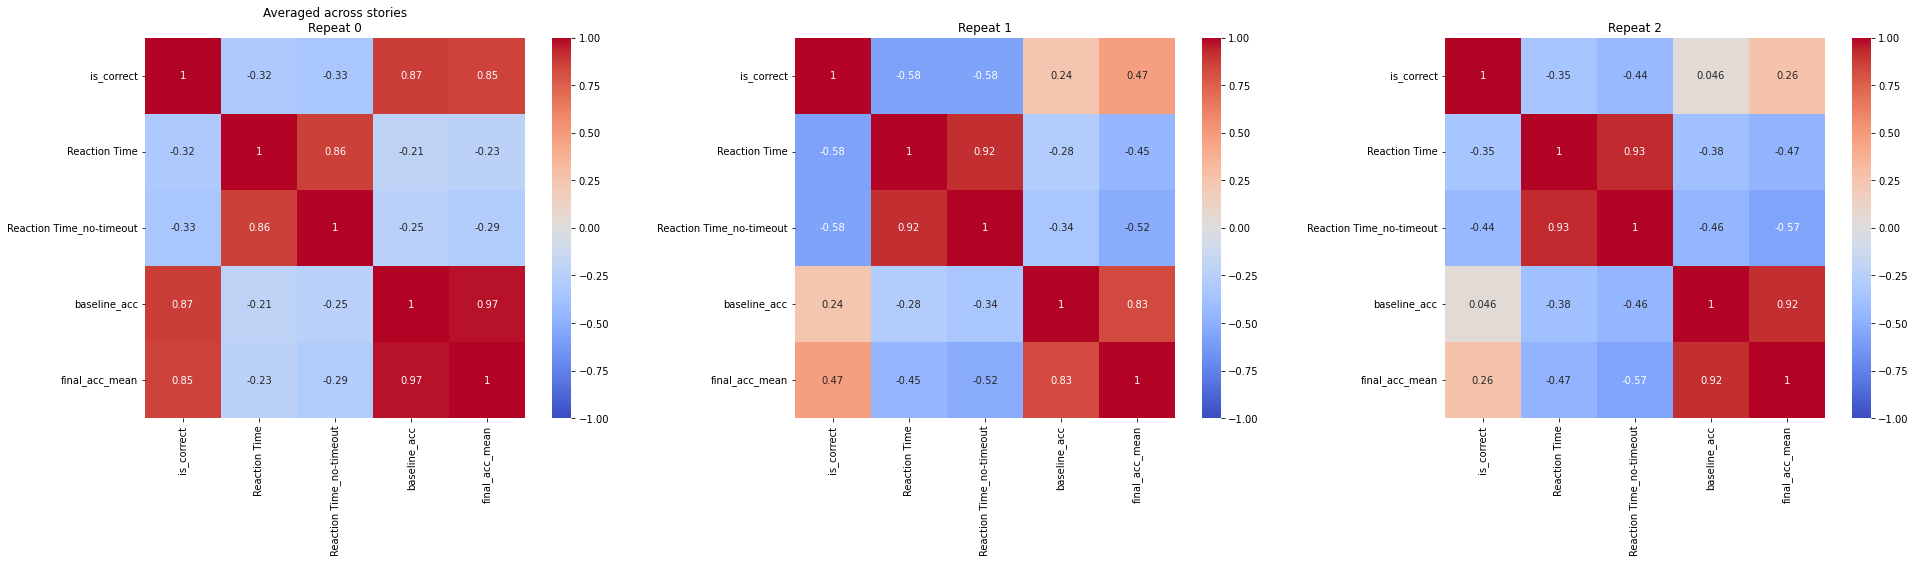

In [45]:
#fig, axs = plt.subplots(len(corr_mats), figsize=(5,7*len(corr_mats))) # vertical
fig, axs = plt.subplots(1,min(3,len(corr_mats_by_rep)), figsize=(11*min(3,len(corr_mats_by_rep)),7)) # horizontal

for ax, (repeat_idx, repeat_corr_mats) in zip(axs, corr_mats_by_rep.items()):
    if repeat_idx >= 3: continue
    avg_repeat_mat = pd.concat({k: v.stack() for k,v in repeat_corr_mats.items()}, axis=1).mean(axis=1).unstack()
    
    sns.heatmap(avg_repeat_mat,cmap='coolwarm',vmin=-1,vmax=1,square=True,annot=True,
                ax=ax)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0) # does this do anything??
    if repeat_idx == 0:
        ax.set_title(f"Averaged across stories\nRepeat {repeat_idx}")
    else:
        ax.set_title(f"Repeat {repeat_idx}")
    print('repeat idx.', repeat_idx)
    print('model-human prob corr:', avg_repeat_mat.loc[['is_correct', 'baseline_acc', 'final_acc_mean']].mean(), sep='\n')
    print()